In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd ./drive/'My Drive'

/content/drive/My Drive


In [3]:
!pip install emoji

     |████████████████████████████████| 51kB 3.8MB/s 


# Import packages

In [1]:
# Packages
from time import time
import re
import os
import nltk
import numpy as np
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from tqdm import tqdm
from time import time
import multiprocessing as mp
import pickle
import string

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from emoji import demojize

from sklearn import naive_bayes, svm, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, roc_curve
from statlearning import plot_confusion_matrix

# Settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
tqdm.pandas(desc="Progress bar")
cores = mp.cpu_count()
warnings.filterwarnings('ignore')
Tokenizer = TweetTokenizer()

In [ ]:
def _apply_df(args):
    df, func, kwargs = args
    return df.progress_apply(func, **kwargs)

def multi_apply(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

# Import dataset

In [ ]:
train = pd.read_csv('train.csv', header=None)

# Merge title and content
train['Text'] = train[1]+' '+train[2]
train = train.drop(columns=[1,2])

# Negative = 0, Positive = 1
train[0] = train[0].map(lambda x: x-1)
train.rename(columns={0:'Sentiment'}, inplace=True)

In [ ]:
test = pd.read_csv('test.csv', header=None)

# Merge title and content
test['Text'] = test[1]+' '+test[2]
test = test.drop(columns=[1,2])

# Negative = 0, Positive = 1
test[0] = test[0].map(lambda x: x-1)
test.rename(columns={0:'Sentiment'}, inplace=True)

In [ ]:
# Merge dataset
fullset = pd.concat([train,test], axis=0, ignore_index=True)
del(train)
del(test)
fullset.to_csv('fullset.csv', index=0)

In [ ]:
fullset = pd.read_csv('fullset.csv')

# Data Observation

In [ ]:
fullset.tail()

,Sentiment,Text
3999995,0,Unbelievable- In a Bad Way We bought this Thom...
3999996,0,"Almost Great, Until it Broke... My son recieve..."
3999997,0,Disappointed !!! I bought this toy for my son ...
3999998,1,Classic Jessica Mitford This is a compilation ...
3999999,0,"Comedy Scene, and Not Heard This DVD will be a..."


In [ ]:
fullset['Sentiment'].value_counts()

1    2000000
0    2000000
Name: Sentiment, dtype: int64

In [ ]:
fullset['Text'] = fullset['Text'].apply(str)

In [ ]:
(fullset['Text'].apply(len)).describe(percentiles=[.95, .99]).round(0)

count    4000000.0
mean         431.0
std          238.0
min            3.0
50%          382.0
95%          894.0
99%          988.0
max         1014.0
Name: Text, dtype: float64

# Data Preprocessing

In [ ]:
# Text lowercase + Stemming
def pre_proc(text):
    return ''.join([PorterStemmer().stem(x) for x in Tokenizer.tokenize(text.lower()) if x != ''])

In [ ]:
fullset['Token'] = multi_apply(fullset['Text'], pre_proc, workers=cores-1)

Progress bar: 100%|██████████| 571429/571429 [55:31<00:00, 171.52it/s]


In [ ]:
fullset = pd.read_csv('fullset_ez_processed.csv')

In [ ]:
fdist = nltk.FreqDist()

In [ ]:
for i in fullset['Token']:
    for word in i.split():
        fdist[word] += 1

In [ ]:
# Count the number of UNIQUE word
features = pd.Series(dict(fdist))
features.describe(percentiles=[.95, .99]).round(0)

count     1804633.0
mean          175.0
std         21403.0
min             1.0
50%             1.0
95%            17.0
99%           271.0
max      15792716.0
dtype: float64

In [ ]:
features_1 = features[features==1]
print('There are',len(features_1),'features which only appear once.')

There are 1246917 words which only appear once.


In [ ]:
print('Some once features are like this:','\''+features_1.index[1]+'\'')
print('So need to re-split them.')

Some once features are like this: 'peaceful.on'
So need to re-split them.


In [ ]:
features_re = features[features<=1]

In [ ]:
relist = [x for x in features_1.index if (not x.isalpha())]

In [ ]:
print('There are',len(relist),'features with punctuations.')

There are 824988 features with punctuations.


In [ ]:
relist_str = ''.join(relist)

In [ ]:
separator = '|'.join(list(set([r'{}'.format(x) for x in relist_str if not x.isalpha()])))
print(separator,'\n')
print(demojize(separator))

🎥|̣|∂|😁|„|'||7|6|̇|~|-|😠|😔|]|≠|☆|#|😍|/|[|9|【|.|_|😩|↓|5|₤||)|⊖|👏|♠|8|💜|1|∅|℉|😡|&||␟|╚|👎|ً|🎉|$|💅|（|💖|⌫|:|😀|}|,|⟨||😎|0|=|>|╝|"|☼|%|<|♡|⊕|;|】|4|′||+|?|†||^|⊂|\|）|‼|{|!|2|😉|̄|@|*|─||♣|||(|3 

:movie_camera:|̣|∂|:beaming_face_with_smiling_eyes:|„|'||7|6|̇|~|-|:angry_face:|:pensive_face:|]|≠|☆|#|:smiling_face_with_heart-eyes:|/|[|9|【|.|_|:weary_face:|↓|5|₤||)|⊖|:clapping_hands:|:spade_suit:|8|:purple_heart:|1|∅|℉|:pouting_face:|&||␟|╚|:thumbs_down:|ً|:party_popper:|$|:nail_polish:|（|:sparkling_heart:|⌫|:|:grinning_face:|}|,|⟨||:smiling_face_with_sunglasses:|0|=|>|╝|"|☼|%|<|♡|⊕|;|】|4|′||+|?|†||^|⊂|\|）|:double_exclamation_mark:|{|!|2|:winking_face:|̄|@|*|─||:club_suit:|||(|3


In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def resplit(text):
    # Translate emojis
    text = demojize(text)
    # Remove punctuation
    for i in string.punctuation:
        text = text.replace(i,' ')
    # Token
    text = Tokenizer.tokenize(text)

    return text

In [ ]:
fullset.Token = fullset.Token.apply(resplit)

In [ ]:
fullset.tail()

,Sentiment,Token
3999995,0,"[unbeliev, in, a, bad, way, we, bought, thi, t..."
3999996,0,"[almost, great, until, it, broke, my, son, rec..."
3999997,0,"[disappoint, i, bought, thi, toy, for, my, son..."
3999998,1,"[classic, jessica, mitford, thi, is, a, compil..."
3999999,0,"[comedi, scene, and, not, heard, thi, dvd, wil..."


In [ ]:
with open('fullset_resplit.pickle', 'wb') as f:
    pickle.dump(fullset, f)

In [ ]:
# Re-count
fdist = nltk.FreqDist()

for i in tqdm(fullset['Token']):
    for word in i:
        fdist[word] += 1

100%|██████████| 4000000/4000000 [06:07<00:00, 10893.40it/s]


In [ ]:
fdist

FreqDist({'the': 15809493, 'i': 9294446, 'and': 8586104, 'a': 8061406, 'to': 7712911, 'it': 7578653, 'of': 6298197, 'thi': 5911844, 'is': 5530069, 'in': 3713530, ...})

In [ ]:
# Count the number of UNIQUE word
features = pd.Series(dict(fdist))
features.describe(percentiles=[.95, .99]).round(0)

count      858011.0
mean          375.0
std         31793.0
min             1.0
50%             1.0
95%            51.0
99%          1065.0
max      15809493.0
dtype: float64

In [ ]:
features_1 = features[features==3]
print('There are',len(features_1),'features which appear only once.')

There are 47820 features which only appear once.


In [ ]:
def rmonce(token):
    return [x for x in token if x not in features_1.index]

In [ ]:
# Remove words which appear only once.
fullset.Token = fullset.Token.progress_apply(rmonce)

Progress bar: 100%|██████████| 4000000/4000000 [14:54<00:00, 4471.89it/s]   


In [ ]:
# Count the length of sentences
(fullset.Token.apply(len)).describe(percentiles=[.95, .99]).round(0)

count    4000000.0
mean          80.0
std           44.0
min            0.0
50%           72.0
95%          165.0
99%          186.0
max          257.0
Name: Token, dtype: float64

In [ ]:
fullset_original = pd.read_csv('fullset.csv')

In [ ]:
print(fullset_original.Text[fullset.Token.apply(len)==0])

294435     ........ ............ ..... ..... ...... ........
3584048    -_- ' ' '''' '''' '' '' ''' '''''? '' '' ' '' ...
Name: Text, dtype: object


In [ ]:
fullset = fullset[fullset.Token.apply(len)!=0]

In [ ]:
(fullset.Token.apply(len)).describe(percentiles=[.95, .99]).round(0)

count    3999998.0
mean          80.0
std           44.0
min            1.0
50%           72.0
95%          165.0
99%          186.0
max          257.0
Name: Token, dtype: float64

In [ ]:
with open('fullset_resplit_rmonce.pickle', 'wb') as f:
    pickle.dump(fullset, f, -1)

In [ ]:
# The most frequent 20 words
fdist.most_common()[:20]

[('the', 15809493),
 ('i', 9294446),
 ('and', 8586104),
 ('a', 8061406),
 ('to', 7712911),
 ('it', 7578653),
 ('of', 6298197),
 ('thi', 5911844),
 ('is', 5530069),
 ('in', 3713530),
 ('for', 3524304),
 ('that', 3245780),
 ('you', 2776538),
 ('wa', 2680975),
 ('not', 2612517),
 ('book', 2498410),
 ('but', 2345642),
 ('with', 2308551),
 ('on', 2281343),
 ('have', 2190331)]

In [ ]:
stopwordls = stopwords.words('english')

In [ ]:
def rmstopword(token):
    return [x for x in token if x not in stopwordls]

In [ ]:
# Remove stopwords
fullset.Token = fullset.Token.apply(rmstopword)

In [ ]:
# Re-count
fdist = nltk.FreqDist()

for i in fullset['Token']:
    for word in i:
        fdist[word] += 1

In [ ]:
# The most frequent 20 words
fdist.most_common(20)

[('thi', 5911844),
 ('wa', 2680975),
 ('book', 2498410),
 ('one', 1590682),
 ('like', 1289538),
 ('great', 1201557),
 ('veri', 1183127),
 ('good', 1167851),
 ('read', 1079779),
 ('use', 1002323),
 ('get', 995575),
 ('time', 944117),
 ('would', 939644),
 ('work', 875548),
 ('ha', 868094),
 ('movi', 773386),
 ('love', 772790),
 ('onli', 714689),
 ('hi', 665482),
 ('realli', 639812)]

In [ ]:
# How many UNIQUE words
len(fdist)

810038

In [ ]:
(fullset.Token.apply(len)).describe(percentiles=[.95, .99]).round(0)

count    3999998.0
mean          44.0
std           24.0
min            1.0
50%           39.0
95%           90.0
99%          102.0
max          212.0
Name: Token, dtype: float64

In [ ]:
fq25, fq50, fq75, fq95, fq99 = 0, 0, 0, 0, 0
count = 0
for i in fdist_df[0]:
    fq25 += fdist.freq(i)
    fq50 += fdist.freq(i)
    fq75 += fdist.freq(i)
    fq95 += fdist.freq(i)
    fq99 += fdist.freq(i)
    count += 1
    if fq25 > 0.25:
        print('The most frequent',count, 'words have 25% portion.')
        fq25 -= 1
    if fq50 > 0.50:
        print('The most frequent',count, 'words have 50% portion.')
        fq50 -= 1
    if fq75 > 0.75:
        print('The most frequent',count, 'words have 75% portion.')
        fq75 -= 1
    if fq95 > 0.95:
        print('The most frequent',count, 'words have 95% portion.')
        fq95 -= 1
    if fq99 > 0.99:
        print('The most frequent',count, 'words have 99% portion.')
        fq99 -= 1
        

The most frequent 55 words have 25% portion.
The most frequent 294 words have 50% portion.
The most frequent 1263 words have 75% portion.
The most frequent 10323 words have 95% portion.
The most frequent 68782 words have 99% portion.


In [ ]:
with open('fullset_resplit_rmonce_nostopword.pickle', 'wb') as f:
    pickle.dump(fullset, f, -1)

# Feature Engineering

In [ ]:
with open('fullset_resplit_rmonce_nostopword.pickle', 'rb') as f:
    fullset = pickle.load(f)

In [ ]:
fullset = pd.read_csv('fullset_resplit_rmonce_nostopword.csv')

In [ ]:
fullset.Token = fullset.Token.apply(str)

In [ ]:
fullset.tail()

,Sentiment,Token
3999993,0,unbeliev bad way bought thi thoma son huge tho...
3999994,0,almost great broke son reciev thi birthday gif...
3999995,0,disappoint bought thi toy son love thoma toy n...
3999996,1,classic jessica mitford thi compil wide rang m...
3999997,0,comedi scene heard thi dvd disappoint get hope...


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(fullset['Token'], fullset['Sentiment'], train_size=0.8, random_state=1, stratify=fullset.Sentiment)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

## Count Vectors + N-gram

In [ ]:
t0 = time()
count_vect_1n = CountVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=10323)
count_vect_1n.fit(fullset['Token'])
print('# CV + 1-gram:', time()-t0)

# CV + 1-gram: 171.18403363227844


In [ ]:
t0 = time()
count_vect_2n = CountVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=r'\w{1,}', max_features=10323)
count_vect_2n.fit(fullset['Token'])
print('# CV + 2-gram:', time()-t0)

# CV + 2-gram: 784.1998519897461


In [ ]:
t0 = time()
count_vect_3n = CountVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=10323)
count_vect_3n.fit(fullset['Token'])
print('# CV + 3-gram:', time()-t0)

# CV + 3-gram: 2854.7060191631317


In [ ]:
# Transform the training and testing data using count vectorizer object
t0 = time()
xtrain_count_1n = count_vect_1n.transform(train_x)
xvalid_count_1n = count_vect_1n.transform(test_x)
print('# Finish CV 1n:', time()-t0)

t0 = time()
xtrain_count_2n = count_vect_2n.transform(train_x)
xvalid_count_2n = count_vect_2n.transform(test_x)
print('# Finish CV 2n:', time()-t0)

t0 = time()
xtrain_count_3n = count_vect_3n.transform(train_x)
xvalid_count_3n = count_vect_3n.transform(test_x)
print('# Finish CV 3n:', time()-t0)

# Finish CV 1n: 188.2530014514923
# Finish CV 2n: 411.8893172740936
# Finish CV 3n: 642.8539836406708


## TF-IDF Vectors + N-gram

In [ ]:
t0 = time()
tfidf_vect_1n = TfidfVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=10323)
tfidf_vect_1n.fit(fullset['Token'])
print('# TF-IDF + 1-gram:', time()-t0)

# TF-IDF + 1-gram: 184.08912563323975


In [ ]:
t0 = time()
tfidf_vect_2n = TfidfVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=r'\w{1,}', max_features=10323)
tfidf_vect_2n.fit(fullset['Token'])
print('# TF-IDF + 2-gram:', time()-t0)

# TF-IDF + 2-gram: 1064.7569992542267


In [ ]:
t0 = time()
tfidf_vect_3n = TfidfVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=10323)
tfidf_vect_3n.fit(fullset['Token'])
print('# TF-IDF + 3-gram:', time()-t0)

# TF-IDF + 3-gram: 3436.6553223133087


In [ ]:
t0 = time()
xtrain_tfidf_1n = tfidf_vect_1n.transform(train_x)
xvalid_tfidf_1n = tfidf_vect_1n.transform(test_x)
print('# Finish TF-IDF 1n:', time()-t0)

t0 = time()
xtrain_tfidf_2n = tfidf_vect_2n.transform(train_x)
xvalid_tfidf_2n = tfidf_vect_2n.transform(test_x)
print('# Finish TF-IDF 2n:', time()-t0)

t0 = time()
xtrain_tfidf_3n = tfidf_vect_3n.transform(train_x)
xvalid_tfidf_3n = tfidf_vect_3n.transform(test_x)
print('# Finish TF-IDF 3n:', time()-t0)

# Finish TF-IDF 1n: 194.93609380722046
# Finish TF-IDF 2n: 461.5940897464752
# Finish TF-IDF 3n: 638.944581747055


## Word2vec

In [2]:
'''
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors
sentence = [(i.split()) for i in fullset.Token]
w2vmodel = word2vec.Word2Vec(sentence, min_count=1, size=100, workers=cores-1)
'''

VECTOR_PATH = 'glove.twitter.27B.200d.txt'
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(VECTOR_PATH)))

1193514it [01:09, 17075.74it/s]


In [3]:
fullset = pd.read_csv('fullset_ez_processed.csv')
fullset.Token = fullset.Token.astype('str')

In [4]:
train_vec, test_vec, train_y, test_y = train_test_split(fullset['Token'], fullset['Sentiment'], train_size=0.8, random_state=1, stratify=fullset.Sentiment)

In [5]:
train_vec = [[embeddings_index[w] for w in x if w in embeddings_index] for x in tqdm(train_vec)]
test_vec = [[embeddings_index[w] for w in x if w in embeddings_index] for x in tqdm(test_vec)]

100%|██████████| 800000/800000 [01:01<00:00, 12916.37it/s]


# Traditional ML

In [6]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_not_svm=True):
    # fit the training dataset on the classifier
    trm = classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = trm.predict(feature_vector_valid)
    
    print('Accuracy:', accuracy_score(predictions, test_y).round(4))
    print('Precision:', precision_score(predictions, test_y).round(4))
    print('Recall:', recall_score(predictions, test_y).round(4))
    print('F1 Score:', f1_score(predictions, test_y).round(4))
    '''
    confusion = confusion_matrix(predictions, test_y)
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(confusion, classes=['negative','positive'], normalize=True)
    plt.show()
    '''
    #print('AUC:', roc_auc_score(test_y, prob[:,1]).round(4),'\n')
    if is_not_svm:
        prob = trm.predict_proba(feature_vector_valid)
        fpr, tpr, _ = roc_curve(test_y, prob[:,1])
        auc = roc_auc_score(test_y, prob[:,1])

        fig, ax= plt.subplots(figsize=(8,6))
        ax.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC curve', fontsize=14)
        sns.despine()
        plt.legend()
        plt.show()

## Naive Bayes

Accuracy: 0.8408
Precision: 0.8541
Recall: 0.8319
F1 Score: 0.8429


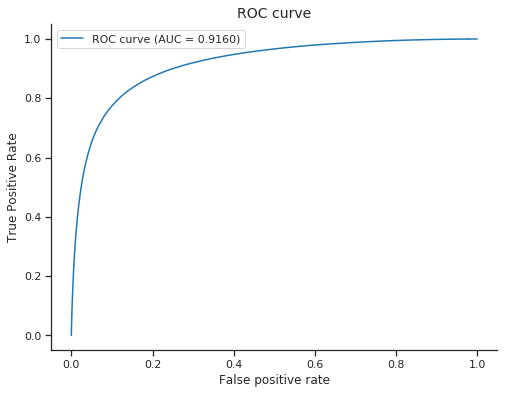

# Naive Bayes + Count Vectors + 1-gram: 5.476766347885132 

Accuracy: 0.8595
Precision: 0.8815
Recall: 0.8444
F1 Score: 0.8625


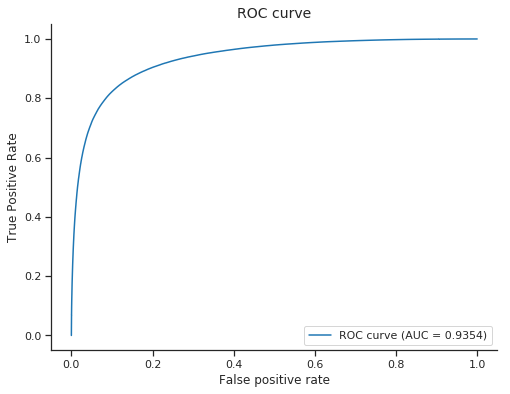

# Naive Bayes + Count Vectors + 2-gram 6.045854330062866 

Accuracy: 0.8594
Precision: 0.8823
Recall: 0.8437
F1 Score: 0.8626


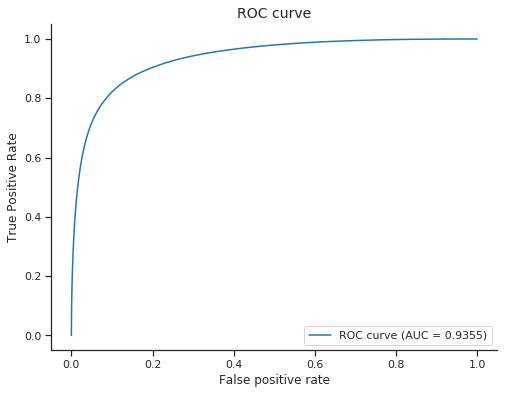

# Naive Bayes + Count Vectors + 3-gram 6.210836410522461 



In [ ]:
t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_count_1n, train_y, xvalid_count_1n)
print("# Naive Bayes + Count Vectors + 1-gram:", time()-t0, '\n')

t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_count_2n, train_y, xvalid_count_2n)
print("# Naive Bayes + Count Vectors + 2-gram", time()-t0, '\n')

t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_count_3n, train_y, xvalid_count_3n)
print("# Naive Bayes + Count Vectors + 3-gram", time()-t0, '\n')

Accuracy: 0.8408
Precision: 0.8541
Recall: 0.8319
F1 Score: 0.8429


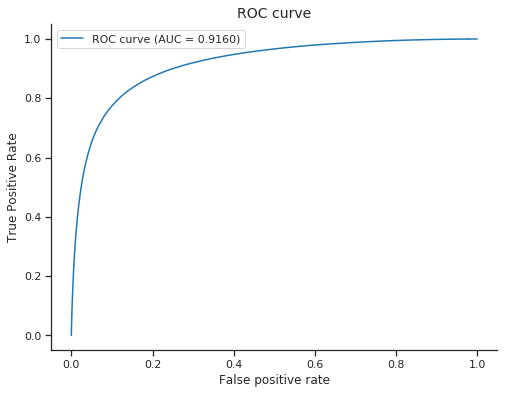

# Naive Bayes + TF-IDF + 1-gram 5.144940137863159 

Accuracy: 0.8595
Precision: 0.8815
Recall: 0.8444
F1 Score: 0.8625


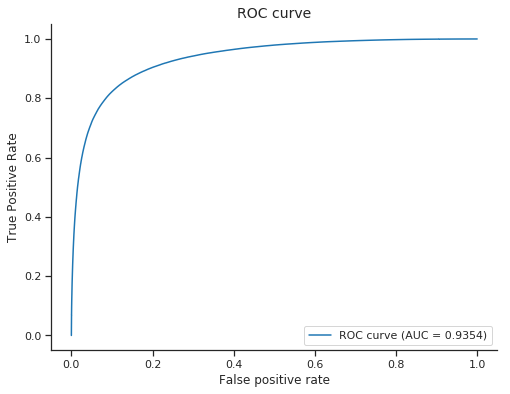

# Naive Bayes + TF-IDF + 2-gram 4.676194190979004 

Accuracy: 0.8594
Precision: 0.8823
Recall: 0.8437
F1 Score: 0.8626


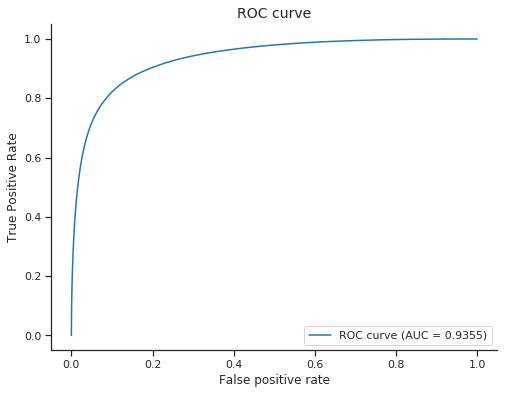

# Naive Bayes + TF-IDF + 3-gram 4.638377904891968 



In [ ]:
t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)
print("# Naive Bayes + TF-IDF + 1-gram", time()-t0, '\n')

t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)
print("# Naive Bayes + TF-IDF + 2-gram", time()-t0, '\n')

t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)
print("# Naive Bayes + TF-IDF + 3-gram", time()-t0, '\n')

In [ ]:
t0 = time()
train_model(naive_bayes.BernoulliNB(), np.array(train_vec).reshape(1,-1), train_y, np.array(test_vec).reshape(1,-1))
print("# Naive Bayes + Word2vec", time()-t0, '\n')

## SVM

In [ ]:
t0 = time()
train_model(svm.LinearSVC(), xtrain_count_1n, train_y, xvalid_count_1n, is_not_svm=False)
print("# SVM + Count Vectors + 1-gram", time()-t0, '\n')

t0 = time()
train_model(svm.LinearSVC(), xtrain_count_2n, train_y, xvalid_count_2n, is_not_svm=False)
print("# SVM + Count Vectors + 2-gram", time()-t0, '\n')

t0 = time()
train_model(svm.LinearSVC(), xtrain_count_3n, train_y, xvalid_count_3n, is_not_svm=False)
print("# SVM + Count Vectors + 3-gram", time()-t0, '\n')

Accuracy: 0.8902
Precision: 0.8979
Recall: 0.8843
F1 Score: 0.891
# SVM + Count Vectors + 1-gram 2241.3633818626404 

Accuracy: 0.9064
Precision: 0.9116
Recall: 0.9023
F1 Score: 0.9069
# SVM + Count Vectors + 2-gram 2235.901044845581 

Accuracy: 0.9062
Precision: 0.9124
Recall: 0.9013
F1 Score: 0.9068
# SVM + Count Vectors + 3-gram 2253.657074689865 



In [ ]:
t0 = time()
train_model(svm.LinearSVC(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n, is_not_svm=False)
print("# SVM + TF-IDF + 1-gram", time()-t0, '\n')

t0 = time()
train_model(svm.LinearSVC(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n, is_not_svm=False)
print("# SVM + TF-IDF + 2-gram", time()-t0, '\n')

t0 = time()
train_model(svm.LinearSVC(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n, is_not_svm=False)
print("# SVM + TF-IDF + 3-gram", time()-t0, '\n')

Accuracy: 0.8911
Precision: 0.894
Recall: 0.8888
F1 Score: 0.8914
# SVM + TF-IDF + 1-gram 116.95248532295227 

Accuracy: 0.9069
Precision: 0.9092
Recall: 0.9049
F1 Score: 0.9071
# SVM + TF-IDF + 2-gram 107.8987967967987 

Accuracy: 0.9067
Precision: 0.9091
Recall: 0.9047
F1 Score: 0.9069
# SVM + TF-IDF + 3-gram 111.7850570678711 



In [ ]:
t0 = time()
train_model(svm.LinearSVC(), train_vec, train_y, valid_vec, is_not_svm=False)
print("# SVM + Word2vec", time()-t0)

## Logistic Regression

Accuracy: 0.8904
Precision: 0.8965
Recall: 0.8858
F1 Score: 0.8911


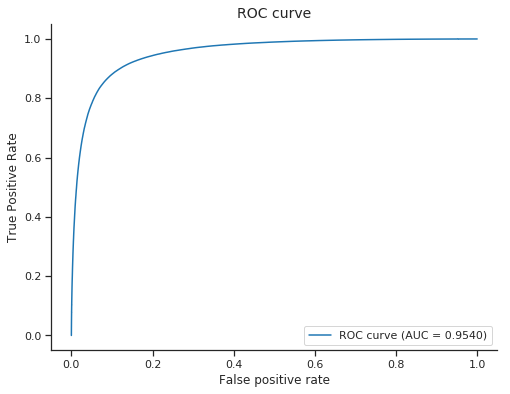

Logistic Regression + Count Vectors + 1-gram 328.32827591896057 

Accuracy: 0.9065
Precision: 0.9107
Recall: 0.9031
F1 Score: 0.9069


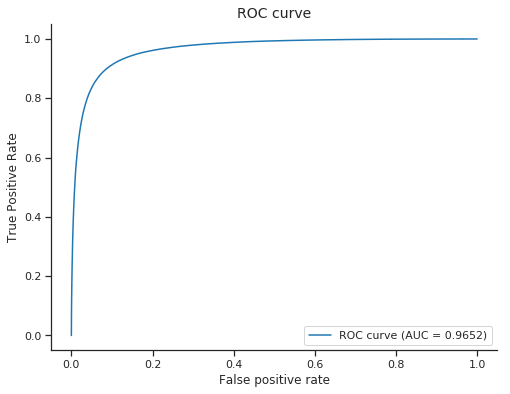


Logistic Regression + Count Vectors + 2-gram 549.03528881073 

Accuracy: 0.9063
Precision: 0.9107
Recall: 0.9028
F1 Score: 0.9067


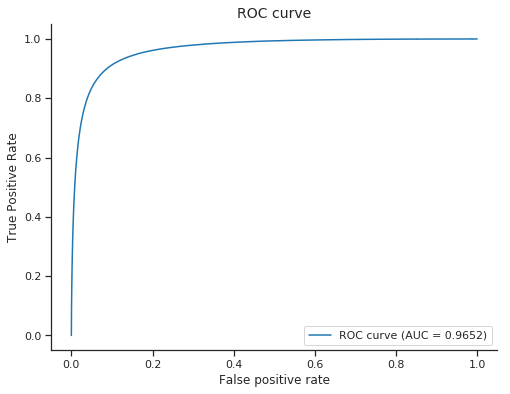


Logistic Regression + Count Vectors + 3-gram 879.6177337169647 



In [ ]:
t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_count_1n, train_y, xvalid_count_1n)
print("Logistic Regression + Count Vectors + 1-gram", time()-t0, '\n')

t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_count_2n, train_y, xvalid_count_2n)
print("\nLogistic Regression + Count Vectors + 2-gram", time()-t0, '\n')

t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_count_3n, train_y, xvalid_count_3n)
print("\nLogistic Regression + Count Vectors + 3-gram", time()-t0, '\n')

Accuracy: 0.8909
Precision: 0.8936
Recall: 0.8889
F1 Score: 0.8912


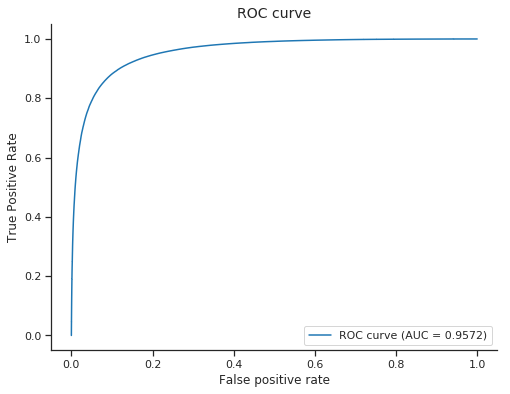

Logistic Regression + TF-IDF + 1-gram 132.99504709243774 

Accuracy: 0.9068
Precision: 0.9089
Recall: 0.9051
F1 Score: 0.907


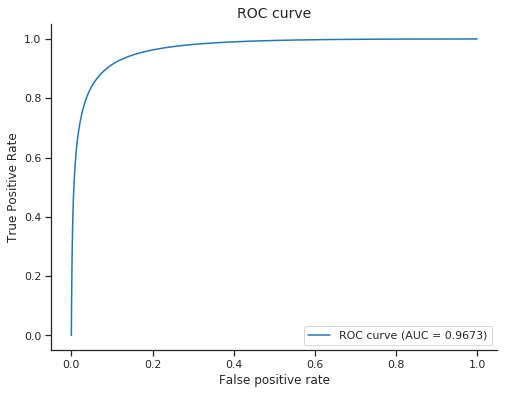


Logistic Regression + TF-IDF + 2-gram 194.40131068229675 

Accuracy: 0.9066
Precision: 0.9089
Recall: 0.9047
F1 Score: 0.9068


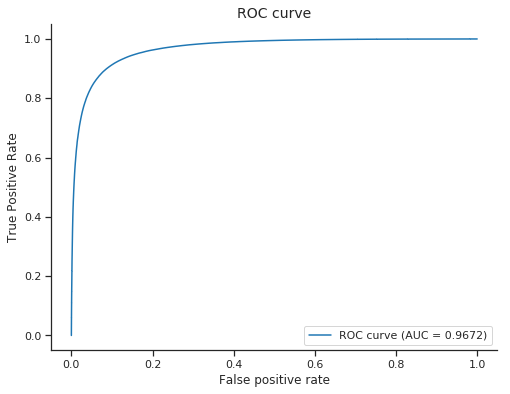


Logistic Regression + TF-IDF + 3-gram 208.38427138328552 



In [ ]:
t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)
print("Logistic Regression + TF-IDF + 1-gram", time()-t0, '\n')

t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)
print("\nLogistic Regression + TF-IDF + 2-gram", time()-t0, '\n')

t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)
print("\nLogistic Regression + TF-IDF + 3-gram", time()-t0, '\n')

In [ ]:
t0 = time()
train_model(linear_model.LogisticRegression(), train_vec, train_y, valid_vec)
print("# Logistic Regression + Word2vec", time()-t0)

# Neural Network

In [5]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
fullset = pd.read_csv('fullset_ez_processed.csv')
fullset.Token = fullset.Token.astype('str')

In [ ]:
MAX_SEQUENCE_LENGTH = 256    
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
word_index = 926452

In [8]:
# One-hot
t0 = time()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(fullset['Token'])
sequences = tokenizer.texts_to_sequences(fullset['Token'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(fullset['Sentiment']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

p1 = int(len(data)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(data)*(1-TEST_SPLIT))
x_train = data[:p1]
y_train = labels[:p1]
x_val = data[p1:p2]
y_val = labels[p1:p2]
x_test = data[p2:]
y_test = labels[p2:]
print('Train rows:', len(x_train))
print('Valid rows:', len(x_val))
print('Test rows:', len(x_test))

print('Time Spent:', time()-t0, 's')

Found 926452 unique tokens.
Shape of data tensor: (4000000, 256)
Shape of label tensor: (4000000, 2)
Train rows: 3200000
Valid rows: 400000
Test rows: 400000
Time Spent: 614.4667632579803 s


In [ ]:
with open('ez-200.pickle', 'rb') as f:
    file = pickle.load(f)
    x_train = file[0]
    y_train = file[1]
    x_val = file[2]
    y_val = file[3]
    x_test = file[4]
    y_test = file[5]
    del(file)

In [ ]:
del(fullset)
del(data)
del(labels)

In [9]:
# Word2vec
# from keras.layers import Embedding
t0 = time()

VECTOR_PATH = 'glove.twitter.27B.200d.txt'

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(VECTOR_PATH)))

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = len(word_index)

# change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) # embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in tqdm(word_index.items()):
    # if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index),
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

print('Time Spent:', time()-t0, 's')

1193514it [01:25, 14039.83it/s]
100%|██████████| 926452/926452 [00:01<00:00, 743312.19it/s]
W0727 22:19:08.216580 140427255142272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Time Spent: 99.69976949691772 s


## CNN

In [1]:
# CNN + One-hot
cnn_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(Embedding(word_index+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn.add(Conv1D(256, 3, padding='valid', activation='elu', strides=1))
cnn.add(MaxPooling1D(3))
# cnn.add(Dropout(0.2))
cnn.add(Flatten())
# cnn.add(Dense(EMBEDDING_DIM, activation='elu'))    # Rapid convergence
cnn.add(Dense(2, activation='sigmoid'))              # Polarity classification
cnn.summary()

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + One-hot 
cnn_result = cnn.evaluate(x_test, y_test)
print('[Test] Loss:', cnn_result[0])
print('[Test] Accuracy:', cnn_result[1])

cnn_t1 = time()-cnn_t0
print('Time Spent:', cnn_t1, 's')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 43010     
Total params: 185,487,466
Trainable params: 185,487,466
Non-trainable params: 0
_________________________________________________________________
Train on 3200000 samples, validate on 400000 samples
Epoch 1/2
3200000/3200000 [==============================] - 1936s 605us/st

In [11]:
# CNN + Word2vec
cnn_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(embedding_layer)
cnn.add(Conv1D(256, 3, padding='valid', activation='elu', strides=1))
cnn.add(MaxPooling1D(3))
# cnn.add(Dropout(0.2))
cnn.add(Flatten())
# cnn.add(Dense(EMBEDDING_DIM, activation='elu'))    # Rapid convergence
cnn.add(Dense(2, activation='sigmoid'))              # Polarity classification
cnn.summary()

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + Word2vec
cnn_result = cnn.evaluate(x_test, y_test)
print('[Test] Loss:', cnn_result[0])
print('[Test] Accuracy:', cnn_result[1])

cnn_t1 = time()-cnn_t0
print('Time Spent:', cnn_t1, 's')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290400 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 43010     
Total params: 185,487,266
Trainable params: 185,487,266
Non-trainable params: 0
_________________________________________________________________
Train on 3200000 samples, validate on 400000 samples
Epoch 1/2
3200000/3200000 [==============================] - 1916s 599us/st

## LSTM (RNN)

In [2]:
# LSTM + One-hot
lstm_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm = Sequential()
lstm.add(Embedding(word_index+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
lstm.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# lstm.add(Dropout(0.2))
# lstm.add(Dense(EMBEDDING_DIM, activation='elu'))
lstm.add(Dense(2, activation='sigmoid'))
lstm.summary()

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: LSTM + One-hot
lstm_result = lstm.evaluate(x_test, y_test)
print('[Test] Loss:', lstm_result[0])
print('[Test] Accuracy:', lstm_result[1])

lstm_t1 = time() - lstm_t0
print('Time Spent:', lstm_t1, 's')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               468992    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 185,760,106
Trainable params: 185,760,106
Non-trainable params: 0
_________________________________________________________________
Train on 3200000 samples, validate on 400000 samples
Epoch 1/2
3200000/3200000 [==============================] - 3263s 1ms/step - loss: 0.1661 - acc: 0.9362 - val_loss: 0.1317 - val_acc: 0.9515
Epoch 2/2
400000/400000 [==============================] - 256s 640us/step
[Test] Loss: 0.1253084249953553
[Test] Accuracy: 0.9543975
Time Spent: 6780.231733322144 s


In [18]:
# LSTM + Word2vec
lstm_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# lstm.add(Dropout(0.2))
# lstm.add(Dense(EMBEDDING_DIM, activation='elu'))
lstm.add(Dense(2, activation='sigmoid'))
lstm.summary()

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: LSTM + Word2vec
lstm_result = lstm.evaluate(x_test, y_test)
print('[Test] Loss:', lstm_result[0])
print('[Test] Accuracy:', lstm_result[1])

lstm_t1 = time() - lstm_t0
print('Time Spent:', lstm_t1, 's')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 200)          185290400 
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 256)               468992    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 185,759,906
Trainable params: 185,759,906
Non-trainable params: 0
_________________________________________________________________
Train on 3200000 samples, validate on 400000 samples
Epoch 1/2
3200000/3200000 [==============================] - 3256s 1ms/step - loss: 0.1596 - acc: 0.9386 - val_loss: 0.1234 - val_acc: 0.9549
Epoch 2/2
400000/400000 [==============================] - 252s 631us/step
[Test] Loss: 0.11840912741206587
[Test] Accuracy: 0.95729125
Time Spent: 6725.5486562252045 s


## CNN + LSTM

In [ ]:
# CNN + LSTM + One-hot
hy_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid = Sequential()
hybrid.add(Embedding(word_index+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
hybrid.add(Conv1D(256, 3, activation='elu'))
hybrid.add(MaxPooling1D(pool_size=3))
# hybrid.add(Dropout(0.2))
hybrid.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# hybrid.add(Dense(EMBEDDING_DIM, activation='elu'))
hybrid.add(Dense(2, activation='sigmoid'))
hybrid.summary()

hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = hybrid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + LSTM + One-hot
hy_result = hybrid.evaluate(x_test, y_test)
print('[Test] Loss:', hy_result[0])
print('[Test] Accuracy:', hy_result[1])

hy_t1 = time() - hy_t0
print('Time Spent:', hy_t1, 's')

W0727 04:38:37.538881 140108065343360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 185,971,306
Trainable params: 185,971,306
Non-trainable params: 0
_________________________________________________________________
Train on 3200000 samples, validate on 400000 samples
Epoch 1/2
3200000/3200000 [==============================] - 2527s 790us/st

In [12]:
# CNN + LSTM + Word2vec
hy_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid = Sequential()
hybrid.add(embedding_layer)
hybrid.add(Conv1D(256, 3, activation='elu'))
hybrid.add(MaxPooling1D(pool_size=3))
# hybrid.add(Dropout(0.2))
hybrid.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# hybrid.add(Dense(EMBEDDING_DIM, activation='elu'))
hybrid.add(Dense(2, activation='sigmoid'))
hybrid.summary()

hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = hybrid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + LSTM + Word2vec
hy_result = hybrid.evaluate(x_test, y_test)
print('[Test] Loss:', hy_result[0])
print('[Test] Accuracy:', hy_result[1])

hy_t1 = time() - hy_t0
print('Time Spent:', hy_t1, 's')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290400 
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 185,971,106
Trainable params: 185,971,106
Non-trainable params: 0
_________________________________________________________________
Train on 3200000 samples, validate on 400000 samples
Epoch 1/2
3200000/3200000 [==============================] - 2425s 758us/st